# Section 1: Business understanding

Question 1: Are there large seasonal variations in Seattle Airbnb pricing? Which weekdays are cheapest / most expensive?

Question 2: How strong is the correlation between review score and price paid?  Score / $ ratio

Question 3: What is my expected revenue with an airbnb listing?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

# Section 2: Data Understanding

In [3]:
# Read in data to separate dataframes
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [4]:
# View and start editing / formatting data frames
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

# Section 3: Data Preparation

In [6]:
# Remove some of the number formatting,, and convert to numeric
calendar['price']=calendar['price'].str.replace('$','')
calendar['price']=calendar['price'].str.replace(',','')
calendar['price']=pd.to_numeric(calendar['price'])

In [7]:
calendar.dtypes

listing_id      int64
date           object
available      object
price         float64
dtype: object

In [8]:
# For each date, calculate the average price, and the standard deviation. 
perdate = calendar.groupby('date')
mean_price = perdate['price'].mean()
number_days = mean_price.size
year_mean = mean_price.mean()
std_price = perdate['price'].std()

In [9]:
# See if we can get average price per weekday
calendar['date'] = pd.to_datetime(calendar['date'])
# translate date to a weekday, 0 = Monday, 6 = Sunday
calendar['week_day'] = calendar['date'].dt.weekday
weekdaymean = calendar.groupby('week_day')['price'].mean()
weekmean = weekdaymean.mean()

In [11]:
#Question 2) Prep. To answer this we need to merge the listings and calendar data frames. For each listing, calculate the average price and the average score
# For each id, calculate the average rental price from calendar df, add to a new df consisting of id, score and avg price
ids = listings['id'].unique()
output = pd.DataFrame(columns=['id','avg_price','avg_review_score'])
for i in ids:
    avg_price = calendar.loc[calendar['listing_id']==i]['price'].mean()
    review_score = listings.loc[listings['id']==i]['review_scores_value'].mean()
    # add i, avg_price, review_score as new entry to df
    output = output.append({'id': i, 'avg_price': avg_price, 'avg_review_score': review_score}, ignore_index=True)

In [12]:
output.head()

,id,avg_price,avg_review_score
0,241032.0,85.000000,10.0
1,953595.0,170.931271,10.0
2,3308979.0,1301.818182,10.0
3,7421966.0,100.000000,NaN
4,278830.0,462.739726,9.0


# Section 5: Data analysis

# Question 1: Are there large seasonal variations in Seattle Airbnb pricing? Which weekdays are cheapest / most expensive?

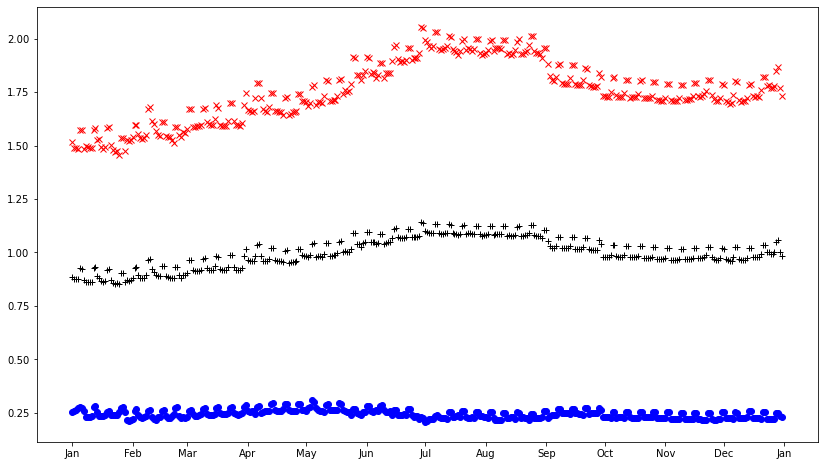

In [13]:
# this plot should answer the seasonal variations .. 
fig, ax = plt.subplots()
ax.plot(mean_price/year_mean,'k+')
ax.plot((mean_price + std_price)/year_mean, 'rx')
ax.plot((mean_price - std_price)/year_mean, 'bo')

# Below code is stolen
# Make ticks on occurrences of each month:
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# '%b' means month as locale’s abbreviated name

fig.set_size_inches(14, 8)

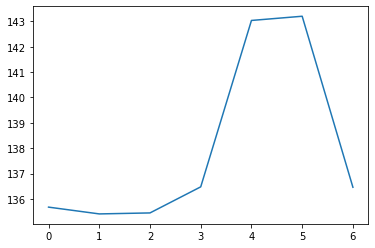

In [23]:
fig, ax = plt.subplots()
ax.plot(weekdaymean)

# Question 2: How strong is the correlation between review score and price paid? Score / Price paid ratio

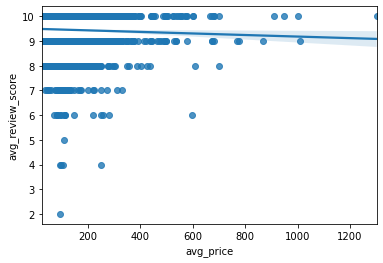

In [16]:
ax = sns.regplot(x="avg_price", y="avg_review_score", data=output)

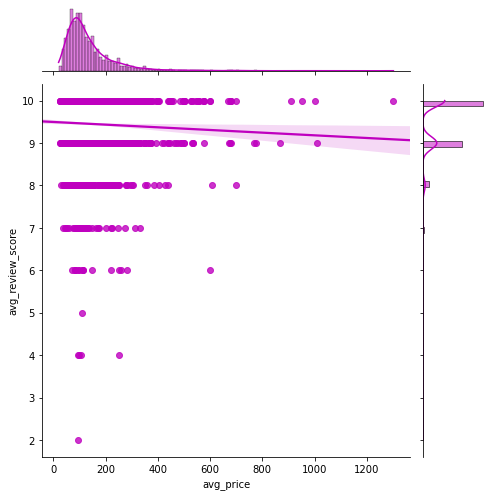

In [17]:
tips = sns.load_dataset("tips")
g = sns.jointplot(x="avg_price", y="avg_review_score", data=output,
                  kind="reg", truncate=False,
                  color="m", height=7)

# Question 3: What is my expected revenue with an airbnb listing?

In [24]:
taken = calendar.loc[calendar['available']=='t'].count()['available']
free = calendar.loc[calendar['available']=='f'].count()['available']
taken / (free + taken)

0.6706100160020666

In [25]:
# Average occupancy rate 67% .. what is average price for the nights when taken? 

In [26]:
calendar['price'].mean() 

137.94485855103355

In [27]:
calendar['price'].sum() / taken
# expected income per year is then:
calendar['price'].mean() * (taken / (free + taken)) * number_days

33765.129387113666